# Data exploration

This notebook gives a brief overview of the (individual second by second ride) data we have. It serves as a first starting point for further processing. We will visualise data (e.g. distributions), provide some bivariate relations and look at outlier / possible erroneous  datapoints. This exploration is the _first_ part of this notebook. The data will be saved and further used in our second notebook **1. Data processing.ipynb** As we will see the second by second data needs extensive processing before we can use it for modelling purposes

In a _second part_ of this notebook we show other data which is not second by second data, but data _derived_ from the second by second data data. This data is also saved and will be used in the **2. Feature engineering.ipynb**

In this notebook we import 3 python (.py) files with helper functions and a config file:
* simple_random_ride_plots.py
* ride_stats_calculation.py
* graph_ride_anomalies.py
* rider_config.json

We will first start with a data dictionary for the second by second data

**Data dictionary**
* filename = name of the ride file
* date = date of the ride
* secs = seconds in ride
* cad = cadence (pedal revolutions per minute)
* hr = heart rate (beats per minute)
* watts = wattage (joule per second)
* alt =  altitude (altitude (meter))
* slope = slope (percentage)
* temp = temperature (Celcius)

Data is obtained by different sensors on a bike which broadcast data to a headunit. Data is then stored on a cycling headunit and was transfered to open source cycling platform Golden Cheeatah. Data used in this project are .csv exports from Golden Cheetah, although the same second by second level data can be used by directly parsing .fit files coming from the headunit. We however used Golden Cheeatah since it also implemented other metrics which could easily be transfered in our modelling process

### Import libraries

In [3]:
import os       
import sys
import glob

import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 999

import pickle

import numpy as np

import gc
import json

from datetime import datetime

# statistics
import phik

import warnings
warnings.filterwarnings('ignore')

# visualisations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# custom functions
from simple_random_ride_plots import simple_ride_plots
from ride_stats_calculation import ride_stats_calculation
from graph_ride_anomalies import graph_ride_anomalies

# Part 1 Second by second ride data

Before using this notebook we made a small rider configuration file (rider_config.json) to set some rider parameters. These parameters are:
* rider_min_hr = rider minimal (rest) heart rate
* rider_max_hr = rider maximum heart rate
* rider_max_watts = rider maximum (1 second) wattage (Pmax)
* rider_max_cad = rider maximum cadence (1 second)

If processing other rider's data first adjust these input parameters

In [4]:
# Read in the configuration file

with open('rider_config.json', 'r') as c:
   rider_params = json.load(c)["rider_params"]

### Read data for rider

**Note** Change PATH in the cel below. 

E.g. 'C:\\LocalData\\Jupyter_Notebooks\\Machine_Learning_Nanodegree\\Capstone_project\\data\\rider1/*.csv'

In [5]:
start_time = datetime.now()

# location of with csv ride datafiles
files = glob.glob('PATH ')

# function read data
def read_process_data():
    df = pd.concat([pd.read_csv(fp).assign(filename=os.path.basename(fp)) for fp in files])

    # process data
    # rename columns
    df.columns = [x.strip() for x in df.columns]
    
    # make columns numeric
    cols_to_numeric = ['secs','cad','hr','watts','alt','slope','temp']
    df[cols_to_numeric] = df[cols_to_numeric].apply(pd.to_numeric, errors='coerce')
    df['date'] = pd.to_datetime(df.filename.str[:10].str.replace('_','/'))

    #remove non-wanted other data
    goodbye_list= ['km','kph','nm','lon','lat','headwind','interval','lrbalance','lte','rte','lps','rps','smo2','thb','o2hb','hhb']
    df.drop(goodbye_list,inplace=True,axis=1)
    
    return df

# invoke function read data
df_raw = read_process_data()

print(df_raw.shape)
print('Number of unique rides rider 1',df_raw.filename.nunique())

print('Time processing', datetime.now()-start_time)

# Make a pickle file for further use in 1. Data processing.ipynb
df_raw.to_pickle('df_raw.pkl')

(4466561, 9)
Number of unique rides rider 1 839
Time processing 0:00:15.654080


In [8]:
#df impression

df_raw.head(5)

,secs,cad,hr,watts,alt,slope,temp,filename,date
0,1,0,50,0,-9.6,0.0,14,2017_01_02_20_00_03.csv,2017-01-02
1,2,0,50,0,-9.6,0.0,14,2017_01_02_20_00_03.csv,2017-01-02
2,3,0,50,0,-9.6,0.0,14,2017_01_02_20_00_03.csv,2017-01-02
3,4,0,50,0,-9.6,0.0,14,2017_01_02_20_00_03.csv,2017-01-02
4,5,68,50,162,-9.6,0.0,14,2017_01_02_20_00_03.csv,2017-01-02


In [5]:
# No missing values

df_raw.isnull().sum()

secs        0
cad         0
hr          0
watts       0
alt         0
slope       0
temp        0
filename    0
date        0
dtype: int64

**Observations:**

We have no missing values (Nans). However this does not mean we don't have odd / erronous data as we will see  in this notebook

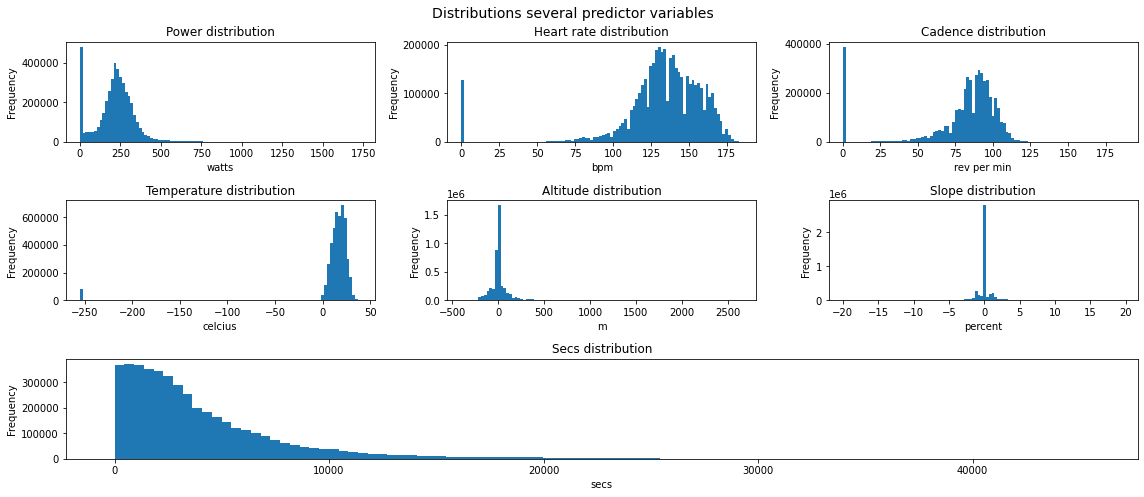

In [119]:
# Plot some initial simple distributions

fig = plt.figure(constrained_layout=True, figsize=(16,7))
gs = fig.add_gridspec(3, 3)
f_ax1 = fig.add_subplot(gs[0, 0])
f_ax2 = fig.add_subplot(gs[0, 1])
f_ax3 = fig.add_subplot(gs[0, 2])
f_ax4 = fig.add_subplot(gs[1, 0])
f_ax5 = fig.add_subplot(gs[1, 1])
f_ax6 = fig.add_subplot(gs[1, 2])
f_ax7 = fig.add_subplot(gs[2, :])

df_raw.watts.plot(kind='hist', bins=100, ax=f_ax1);
f_ax1.set_title('Power distribution');
f_ax1.set_xlabel('watts')
df_raw.hr.plot(kind='hist', bins=100, ax=f_ax2);
f_ax2.set_title('Heart rate distribution');
f_ax2.set_xlabel('bpm')
df_raw.cad.plot(kind='hist', bins=100, ax=f_ax3);
f_ax3.set_title('Cadence distribution');
f_ax3.set_xlabel('rev per min')
df_raw.temp.plot(kind='hist', bins=100, ax=f_ax4);
f_ax4.set_title('Temperature distribution');
f_ax4.set_xlabel('celcius')
df_raw.alt.plot(kind='hist', bins=100, ax=f_ax5);
f_ax5.set_title('Altitude distribution');
f_ax5.set_xlabel('m')
df_raw.slope.plot(kind='hist', bins=100, ax=f_ax6);
f_ax6.set_title('Slope distribution');
f_ax6.set_xlabel('percent')
df_raw.secs.plot(kind='hist', bins=100, ax=f_ax7);
f_ax7.set_title('Secs distribution');
f_ax7.set_xlabel('secs')
fig.suptitle('Distributions several predictor variables',  fontsize=14)
plt.tight_layout()
fig.subplots_adjust(top=0.91)

In [8]:
# simple overall overview

df_raw.describe().apply(lambda s: s.apply('{0:.1f}'.format))[0:]

,secs,cad,hr,watts,alt,slope,temp
count,4466561.0,4466561.0,4466561.0,4466561.0,4466561.0,4466561.0,4466561.0
mean,4198.7,79.3,132.9,217.2,27.6,0.0,12.2
std,4569.7,28.0,29.9,120.2,183.7,1.4,37.5
min,1.0,0.0,0.0,0.0,-402.0,-20.0,-255.0
25%,1378.0,76.0,123.0,161.0,-18.0,-0.0,12.0
50%,2894.0,87.0,136.0,225.0,0.0,0.0,17.0
75%,5419.0,96.0,151.0,285.0,24.0,0.0,22.0
max,45420.0,187.0,247.0,1733.0,2657.0,19.7,40.0


**Observations**
* Power: Distribution has zero values (no wattage / possible data dropouts / rides with no wattage data) and a long tail related to either maximum efforts for a short period and/or possible outliers
* Heart rate: Zero values (possible data dropouts / rides with no heart rate data recorded) and a long tail (maximum heart rate / outlier heart rate values)
* Cadence: Zero cadence (no cadence recorded / no pedalling) and a tail with possible outliers
* Temperature: A very strange spike at -255 (no temperature recorded)
* Altitude: Low altitude in general (note that rider's data comes from a country with no mountains / flat). Few datapoints with altitude in general for rides abroad
* Slope: A lot of zero values (see also related comments at altitude)
* Secs: Most rides seem shorter than 5000 seconds. Only a few very long recordings (rides)

Here we try to get an initial idea on second to second relations between the variables. Later **3. Feature exploration and selection.ipynb** we will get more into detail about variable relations

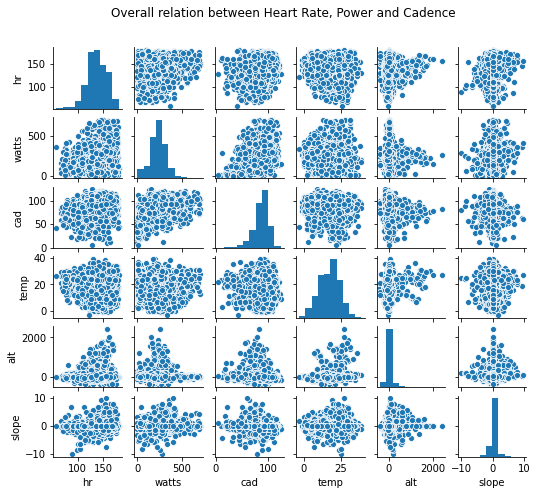

In [104]:
# Simple pairplot for bivariate relations in sample (n=5000), note that we plot within normal ranges of riders physiology / capability and watts/cad >0

g = sns.pairplot(df_raw[['hr','watts','cad','temp','alt','slope']].loc[((df_raw.watts>0) & (df_raw.watts<700)) & ((df_raw.hr>rider_params['rider_min_hr']) & (df_raw.hr<rider_params['rider_max_hr'])) & ((df_raw.cad>0) & (df_raw.cad<rider_params['rider_max_cad'])) & (df_raw.temp>-255)].sample(5000, random_state=101))
g.fig.suptitle("Overall relation between Heart Rate, Power and Cadence", y=1.08)
g.fig.set_size_inches(7,6)

interval columns not set, guessing: ['hr', 'watts', 'cad', 'temp', 'alt', 'slope']


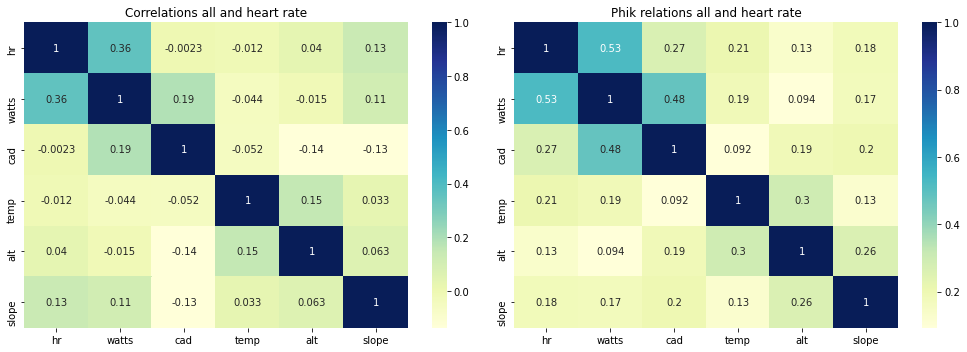

In [113]:
# Show some correlations and phik values on a small random sample (n=100000), note that we plot within normal ranges of riders physiology / capability and watts/cad >0

import phik

fig, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(14,5))

sns.heatmap(df_raw[['hr','watts','cad','temp','alt','slope']].loc[((df_raw.watts>0) & (df_raw.watts<700)) & ((df_raw.hr>rider_params['rider_min_hr']) & (df_raw.hr<rider_params['rider_max_hr'])) & ((df_raw.cad>0) & (df_raw.cad<rider_params['rider_max_cad'])) & (df_raw.temp>-255)].sample(100000, random_state=101).corr(), annot=True, ax=ax1, cmap="YlGnBu")
ax1.title.set_text('Correlations all and heart rate');

sns.heatmap(df_raw[['hr','watts','cad','temp','alt','slope']].loc[((df_raw.watts>0) & (df_raw.watts<700)) & ((df_raw.hr>rider_params['rider_min_hr']) & (df_raw.hr<rider_params['rider_max_hr'])) & ((df_raw.cad>0) & (df_raw.cad<rider_params['rider_max_cad'])) & (df_raw.temp>-255)].sample(100000, random_state=101).phik_matrix(), annot=True, ax=ax2, cmap="YlGnBu")
ax2.title.set_text('Phik relations all and heart rate');
plt.tight_layout()

**Observations**
* Power seems to be mostly related to heart rate
* We see that taking into account non-linearity the relations for all variables with heart rate become stronger (see different values correlations versus phik)

Lets plot some individual rides. We use a small function for plotting heart rate, power (watts) and cadence for a random selection of files

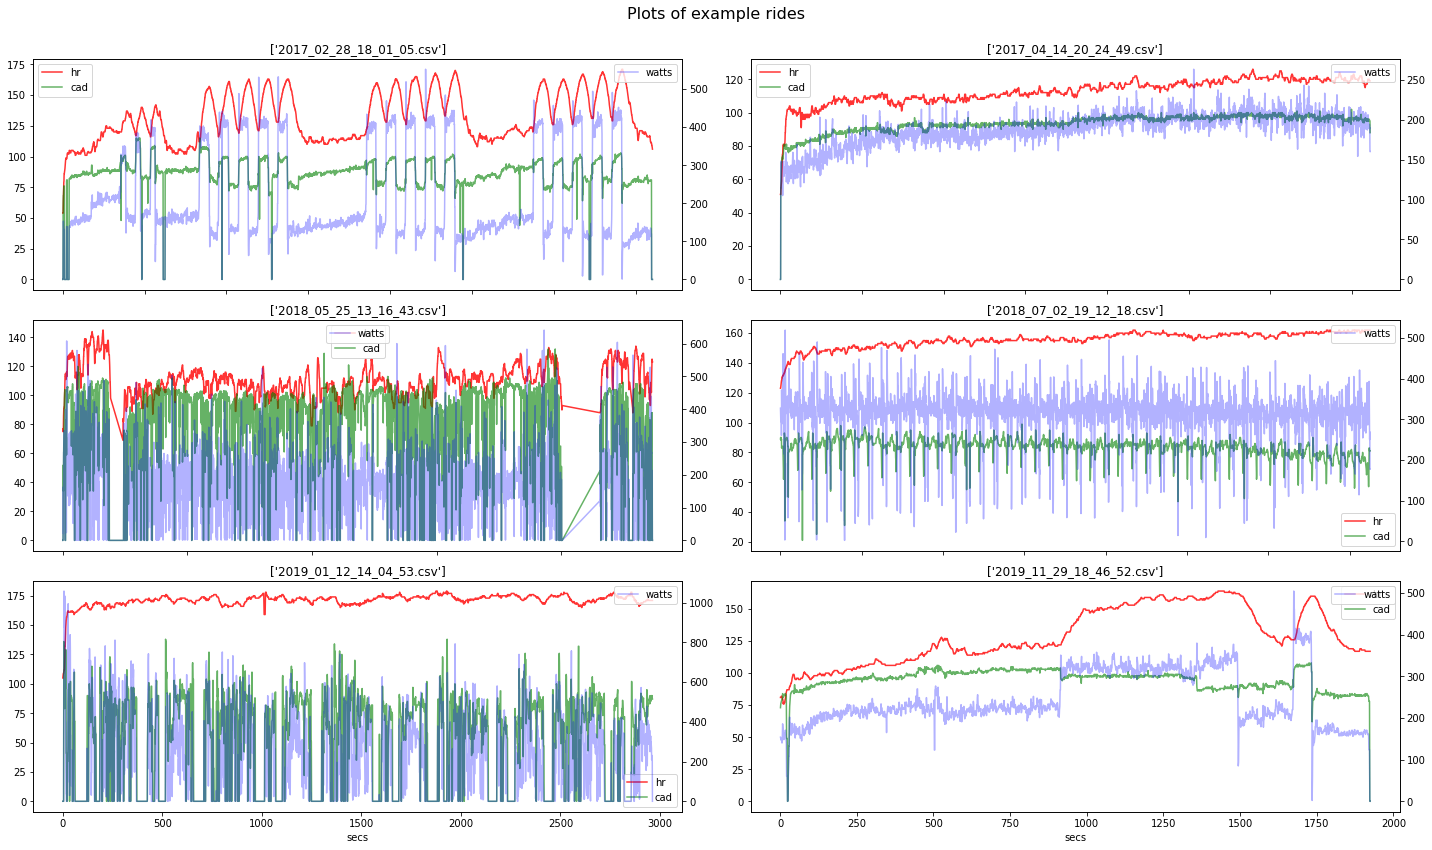

In [4]:
# randomly plot some example rides using custom function
simple_ride_plots(df_raw, 6, 3, 2)

**Observations**

After randomly going through some of the ride files we already observed a lot of things: 
* Heart rate is much more stable in development that power (watts) which is stochastic in nature
* Heart rate follows power development in a lagged manner
* There are structured (stable power blocks) and unstructured rides
* Power (watts) and cadence registration is very much paired (if one goes to zero, the other does so to)
* Heart rate development with structured blocks seem to show an increasing similar pattern, meaning that the shape of the curve kind of stays the same but the height of the heart rate tends to increase
* In long stable power periods heart rate tends to show an increasing trend
* The level of heart rate is very strongly tied to the power level

Also we observed patterns which need our attention in further data processing:
* Data drops for heart rate which go to zero occasionally
* Data drops for heart rate for consecutive periods
* Data drops for heart rate which don't go to zero but don't seem to fit the regular trend
* No data recordings for power/cadence at beginning of rides (rider still has to get on the bike)
* No data recordings of power/cadence at end of the ride (rider goes off the bike and stops headunit later)
* No power/cadence data for a longer period while heart rate keeps recording (rider not riding)
* Data "freezes" for both power and heart rate
* Periods with no movement (no power/ cadence data / no heart rate data)
* Multiple suddden data drops for the power (watts) within _seemingly_ structured intervals
     
In addition to plotting ride files randomly we also created a small Dash app (dash_chart_rides_interactive.py) which can be used to select rides and go through each desired ride instead of random ride files. Input file is the second by second file, which first has to be stored as a pickle file and then this pickled file name has to be changed in the code of the Dash app (defined by the tag: _# define the dataset here_)

The next part of our data exploration is more on ride level. We have grouped data which means that the second by second data are part of a group, in this case an individual ride. This data "hierarchy" is something we will also use in later modelling procedures, because individual datapoints in a ride belong to that ride and we don not want to "break" that dependency structure. For calculating statistics (which can also relate to identifying data anomalies) we a.o. take into account prior information about the rider which was configured in our rider config file

In [4]:
# We first overwrite hr data to zero to indicate single heart rate (hr) anomalies either below the rest heart rate and above the maximum heart rate
# The purpose is for further processing later

df_raw['hr'] = np.where(((df_raw['hr']<rider_params['rider_min_hr']) | (df_raw['hr']>rider_params['rider_max_hr'])), 0, df_raw['hr'])

# add indicator hr_power is zero (complete dropouts / either from caused by heart rate anomaly)
df_raw['hr_power_zero'] = np.where((df_raw['hr']==0) & (df_raw['watts'] == 0) , 0,1)
df_raw['hr_power_ratio'] = np.round(df_raw['watts']/df_raw['hr']*100, 2)

# add some indicators for consecutive similar values for variables that might be used for modelling further
df_raw['consecutive_hr_similar_values'] = df_raw.hr.groupby([df_raw.filename, df_raw.hr.diff().ne(0).cumsum()]).transform('size')
df_raw['consecutive_power_similar_values'] = df_raw.watts.groupby([df_raw.filename, df_raw.watts.diff().ne(0).cumsum()]).transform('size')
df_raw['consecutive_cad_similar_values'] = df_raw.cad.groupby([df_raw.filename, df_raw.cad.diff().ne(0).cumsum()]).transform('size')
df_raw['consecutive_hr_power_ratio_similar_values'] = df_raw.hr_power_ratio.groupby([df_raw.filename, df_raw.hr_power_ratio.diff().ne(0).cumsum()]).transform('size')

We will generate ride level statistics along with a selection of possible variables which can relate to anomalies. We wrote a small function for that

In [5]:
# invoke custom function
df_stats = ride_stats_calculation(df_raw)
df_stats.head(5)

,filename,count_records,mean_hr,mean_cad,mean_power,mean_temp,mean_alt,mean_slope,min_hr,max_hr,min_cad,max_cad,min_power,max_power,min_temp,max_temp,min_alt,max_alt,min_slope,max_slope,std_hr,std_power,cv_hr,cv_power,count_zero_hr,count_zero_cad,count_zero_power,perc_count_zero_hr,perc_count_zero_cad,perc_count_zero_power,count_zero_hr_power,perc_count_zero_hr_power,hr_longest_zero_run,cad_longest_zero_run,power_longest_zero_run,perc_hr_longest_zero_run,perc_cad_longest_zero_run,perc_power_longest_zero_run,count_power_extremes,count_cad_extremes,perc_power_extremes,perc_cad_extremes,consecutive_hr_similar_values,perc_consecutive_hr_similar_values,consecutive_power_similar_values,perc_consecutive_power_similar_values,consecutive_cad_similar_values,perc_consecutive_cad_similar_values,consecutive_hr_power_ratio_similar_values,perc_consecutive_hr_power_ratio_similar_values
0,2017_01_02_20_00_03.csv,3663,151.017472,84.502594,251.849850,7.180726,-9.969206,0.008655,50,175,0,103,0,375,6,14,-11.6,-8.6,-1.835940,1.384620,20.396807,7926.911911,0.14,31.47,0,70,132,0.0,2.0,4.0,0,0.0,0,6,7,0.0,0.0,0.0,0,0,0.0,0.0,42,1.0,7,0.0,17,0.0,7,0.0
1,2017_01_03_20_07_36.csv,3065,146.652202,82.800653,255.368352,8.397716,33.758238,0.051991,100,170,0,97,0,363,7,16,29.2,37.6,-1.407380,1.398600,16.084239,6477.967732,0.11,25.37,0,38,92,0.0,1.0,3.0,0,0.0,0,6,7,0.0,0.0,0.0,0,0,0.0,0.0,48,2.0,7,0.0,22,1.0,7,0.0
2,2017_01_07_19_57_46.csv,5293,142.624410,86.448139,210.336671,6.716229,0.929567,-0.007630,47,167,0,110,0,433,5,15,-0.4,1.8,-8.771930,8.733620,16.316487,8200.055187,0.11,38.99,0,373,661,0.0,7.0,12.0,0,0.0,0,11,14,0.0,0.0,0.0,0,0,0.0,0.0,48,1.0,14,0.0,20,0.0,14,0.0
3,2017_01_08_18_02_53.csv,3519,142.388463,75.014493,222.116510,9.913328,15.693549,0.014682,59,168,0,98,0,380,9,17,14.0,17.4,-0.932401,0.943315,18.175116,11744.222351,0.13,52.87,0,285,496,0.0,8.0,14.0,0,0.0,0,12,16,0.0,0.0,0.0,0,0,0.0,0.0,53,2.0,16,0.0,16,0.0,16,0.0
4,2017_01_10_19_48_18.csv,3622,133.202374,83.098564,196.522363,10.163722,2.162120,-0.003196,74,174,0,103,0,369,9,16,0.8,3.8,-0.611377,7.299270,21.004797,9691.451447,0.16,49.31,0,167,312,0.0,5.0,9.0,0,0.0,0,20,21,0.0,1.0,1.0,0,0,0.0,0.0,51,1.0,21,1.0,20,1.0,21,1.0


In [6]:
# Remove all rides with no HR data (our target variable) at all in the ride since this is our target variable

print('We have', df_stats.shape[0], 'ride files')

df_stats = df_stats[~df_stats.filename.isin(df_stats['filename'].loc[df_stats.mean_hr==0])];

print('We now have', df_stats.filename.nunique(), 'ride files')

#keep records with hr data in stats table
df_stats = df_stats.loc[df_stats.mean_hr>0];

We have 839 ride files
We now have 812 ride files


In [7]:
# Remove all rides with no power data at all in the ride since this is our main independent variable

print('We had', df_stats.shape[0], 'ride files')

df_stats = df_stats[~df_stats.filename.isin(df_stats['filename'].loc[df_stats.mean_power==0])];

print('We now have', df_stats.filename.nunique(), 'ride files')

#keep records with wattage data in stats table
df_stats = df_stats.loc[df_stats.mean_power>0];

We had 812 ride files
We now have 786 ride files


In [8]:
# Remove all rides with no cadence data at all in the ride since this will also be independent variable

print('We had', df_stats.shape[0], 'ride files')

df_stats = df_stats[~df_stats.filename.isin(df_stats['filename'].loc[df_stats.mean_cad==0])];

print('We now have', df_stats.filename.nunique(), 'ride files')

#keep records with cadence data in stats table
df_stats = df_stats.loc[df_stats.mean_cad>0];

We had 786 ride files
We now have 786 ride files


We started with 839 files. Now we have 786 files left. Let's visualize some more of this ride level data in the remainder of part 1 of this notebook

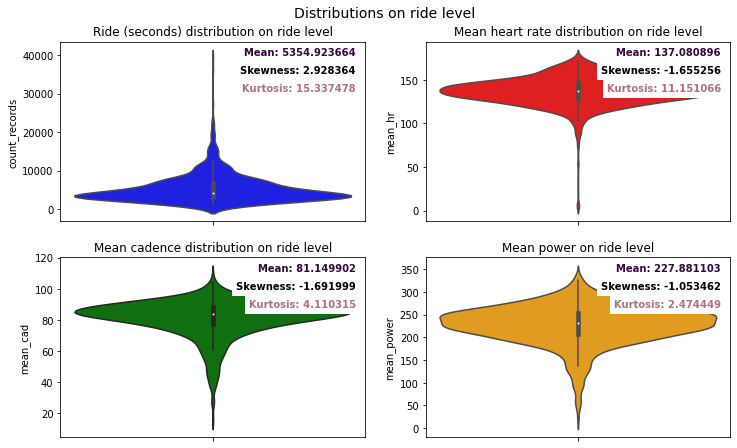

In [149]:
# Plot basic distributions

fig, axes = plt.subplots(2, 2, figsize=(12, 7))

sns.violinplot(df_stats.count_records, data = df_stats, orient='v',  ax=axes[0,0], color='blue')
axes[0,0].set_title('Ride (seconds) distribution on ride level');

sns.violinplot(df_stats.mean_hr, data = df_stats, orient='v', ax=axes[0,1], color='r')
axes[0,1].set_title('Mean heart rate distribution on ride level');

sns.violinplot(df_stats.mean_cad, data = df_stats, orient='v', ax=axes[1,0], color='g')
axes[1,0].set_title('Mean cadence distribution on ride level')

sns.violinplot(df_stats.mean_power, data = df_stats, orient='v', ax=axes[1,1], color='orange')
axes[1,1].set_title('Mean power on ride level');

for i, ax in enumerate(axes.reshape(-1)):
    ax.text(x=0.97, y=0.97, transform=ax.transAxes, s="Mean: %f" % df_stats.iloc[:,i+1].mean(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:dark purple')
    ax.text(x=0.97, y=0.87, transform=ax.transAxes, s="Skewness: %f" % df_stats.iloc[:,i+1].skew(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:black')
    ax.text(x=0.97, y=0.77, transform=ax.transAxes, s="Kurtosis: %f" % df_stats.iloc[:,i+1].kurt(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:mauve')
fig.suptitle('Distributions on ride level',  fontsize=14)
fig.subplots_adjust(top=0.91)
#plt.tight_layout()

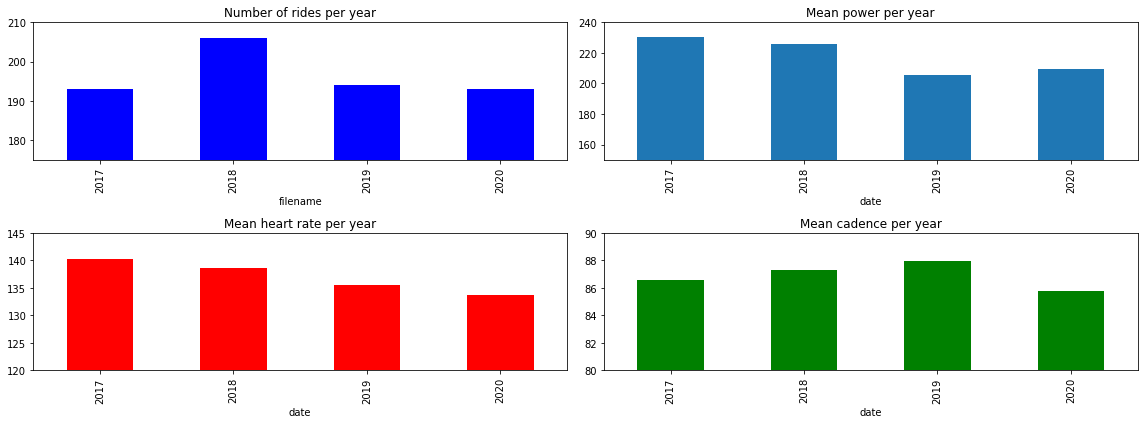

In [156]:
# Plot some statistics on yearly level

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(16,6))

df_stats.groupby(df_stats.filename.str[0:4]).size().plot(kind='bar', color='b', ax=ax1);
ax1.set_title('Number of rides per year');
ax1.set_ylim(175,210);

df_raw.groupby(pd.DatetimeIndex(df_raw['date']).year)['watts'].mean().plot(kind='bar', ax=ax2);
ax2.set_title('Mean power per year');
ax2.set_ylim(150,240);

df_raw.loc[df_raw.hr>0].groupby(pd.DatetimeIndex(df_raw[df_raw.hr>0]['date']).year)['hr'].mean().plot(kind='bar', color='r', ax=ax3);
ax3.set_title('Mean heart rate per year');
ax3.set_ylim(120,145);

df_raw.loc[df_raw.cad>0].groupby(pd.DatetimeIndex(df_raw[df_raw.cad>0]['date']).year)['cad'].mean().plot(kind='bar', color='g', ax=ax4);
ax4.set_title('Mean cadence per year')
ax4.set_ylim(80,90);

plt.tight_layout()

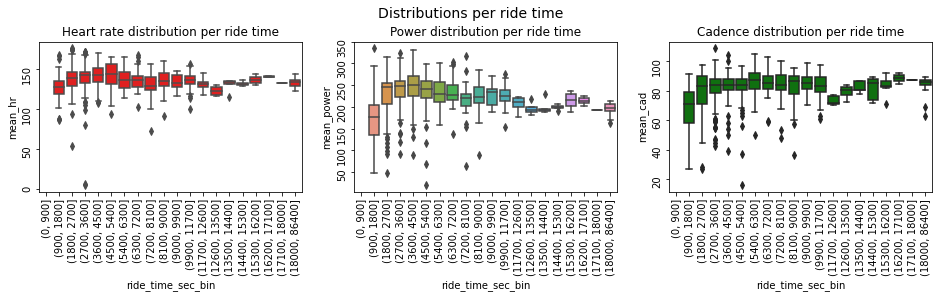

In [163]:
# Plot some statistics based on ride time

cut_bins = [0, 900, 1800, 2700, 3600, 4500, 5400, 6300, 7200, 8100, 9000, 9900, 11700, 12600, 13500, 14400, 15300, 16200, 17100, 18000, 86400]
df_stats['ride_time_sec_bin'] = pd.cut(df_stats['count_records'],bins=cut_bins)

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3,figsize=(16,3))

sns.boxplot(x = df_stats.ride_time_sec_bin, y="mean_hr", data = df_stats, orient='v', ax=ax1, color='r')
ax1.set_title('Heart rate distribution per ride time');
sns.boxplot(x= df_stats.ride_time_sec_bin, y="mean_power", data = df_stats, orient='v', ax=ax2)
ax2.set_title('Power distribution per ride time')
sns.boxplot(x= df_stats.ride_time_sec_bin, y="mean_cad", data = df_stats, orient='v', ax=ax3, color='g')
ax3.set_title('Cadence distribution per ride time')
fig.suptitle('Distributions per ride time',  fontsize=14)
for ax in fig.axes:
    ax.tick_params(labelrotation=90);
fig.subplots_adjust(top=0.82)

**Observations** 

All have strong positive kurtosis which means heavier tails than a normal distribution. Ride time shows a positive skewness meaning larger right tail. Other variables show a left tail (negative skewness) on ride level. Moreover even on ride level we see tails on heart rate, power and cadence which should be examined further. The average ride time is around 1.5 hours. Also we see some very short rides (see also table below)

In [123]:
# simple overall ride level overview

df_stats.describe().apply(lambda s: s.apply('{0:.1f}'.format))[0:]

,count_records,mean_hr,mean_cad,mean_power,mean_temp,mean_alt,mean_slope,min_hr,max_hr,min_cad,max_cad,min_power,max_power,min_temp,max_temp,min_alt,max_alt,min_slope,max_slope,std_hr,std_power,cv_hr,cv_power,count_zero_hr,count_zero_cad,count_zero_power,perc_count_zero_hr,perc_count_zero_cad,perc_count_zero_power,count_zero_hr_power,perc_count_zero_hr_power,hr_longest_zero_run,cad_longest_zero_run,power_longest_zero_run,perc_hr_longest_zero_run,perc_cad_longest_zero_run,perc_power_longest_zero_run,count_power_extremes,count_cad_extremes,perc_power_extremes,perc_cad_extremes,consecutive_hr_similar_values,perc_consecutive_hr_similar_values,consecutive_power_similar_values,perc_consecutive_power_similar_values,consecutive_cad_similar_values,perc_consecutive_cad_similar_values,consecutive_hr_power_ratio_similar_values,perc_consecutive_hr_power_ratio_similar_values
count,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0,786.0
mean,5354.9,137.1,81.1,227.9,9.6,13.1,0.0,47.0,163.9,1.5,116.2,2.0,621.5,7.9,13.6,-5.7,37.2,-4.0,4.1,15.8,12920.8,0.1,58.5,32.8,281.3,318.4,0.8,5.8,6.6,4.0,0.1,15.4,29.9,31.8,0.4,0.8,0.8,0.0,0.1,0.0,0.0,49.5,1.2,33.0,0.8,35.9,0.9,30.7,0.7
std,3894.8,16.3,11.9,43.2,46.5,137.2,0.2,38.6,13.2,9.2,15.2,16.6,232.1,46.2,47.0,104.7,200.4,4.3,4.2,7.2,13397.7,0.2,57.6,199.6,459.9,497.8,5.5,9.0,9.8,23.8,1.1,148.4,90.8,91.5,4.3,2.9,2.9,0.1,0.6,0.0,0.0,147.4,4.3,91.3,2.9,89.6,2.9,88.8,2.6
min,946.0,5.5,16.1,20.6,-255.0,-400.2,-3.6,0.0,110.0,0.0,81.0,0.0,236.0,-255.0,-255.0,-402.0,-398.0,-20.0,0.0,3.1,104.1,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,3.0,0.0,7.0,0.0,3.0,0.0
25%,3035.0,128.8,77.1,206.8,12.2,-16.5,0.0,0.0,156.0,0.0,105.0,0.0,459.0,10.0,18.0,-30.0,-7.0,-5.7,0.0,10.7,5217.0,0.1,22.5,0.0,21.2,26.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,1.0,7.0,0.0,15.0,0.0,6.0,0.0
50%,4083.0,137.4,83.7,231.4,17.6,0.0,0.0,62.0,166.0,0.0,114.0,0.0,566.5,16.0,22.0,-5.6,8.0,-3.3,3.6,15.4,8275.3,0.1,37.6,0.0,140.0,152.5,0.0,3.0,3.0,0.0,0.0,0.0,15.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,1.0,16.0,0.0,20.0,0.0,15.0,0.0
75%,6853.8,146.3,88.6,254.3,22.4,20.5,0.0,76.0,173.0,0.0,124.0,0.0,729.8,21.0,25.0,9.8,34.0,0.0,6.2,19.2,14464.4,0.1,68.9,6.0,371.0,411.8,0.0,7.0,8.0,0.0,0.0,3.0,27.0,29.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,44.0,1.0,29.0,1.0,30.0,1.0,28.0,1.0
max,39330.0,175.9,108.6,334.8,37.7,1369.0,2.2,155.0,185.0,78.0,187.0,248.0,1733.0,34.0,39.0,835.0,2657.0,0.0,19.7,68.0,87209.3,5.0,351.7,3296.0,6220.0,6408.0,96.0,70.0,75.0,375.0,27.0,3296.0,2129.0,2131.0,94.0,45.0,45.0,1.0,11.0,0.0,0.0,3296.0,94.0,2131.0,45.0,2129.0,45.0,2131.0,45.0


Lets also plot some of our data fields which might be related to data anomalies

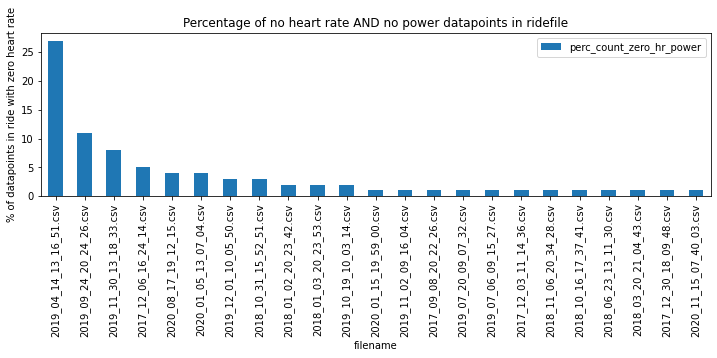

In [117]:
# inspect distribition rides datapoints with no power data and no hr data but with a long ranges of zero power and zero HR

df_stats[['filename','perc_count_zero_hr_power']].loc[df_stats.perc_count_zero_hr_power>0].sort_values(by=['perc_count_zero_hr_power'], ascending = False).set_index(['filename']).plot(kind='bar', figsize=(12,3))
plt.title('Percentage of no heart rate AND no power datapoints in ridefile')
plt.ylabel('% of datapoints in ride with zero heart rate');

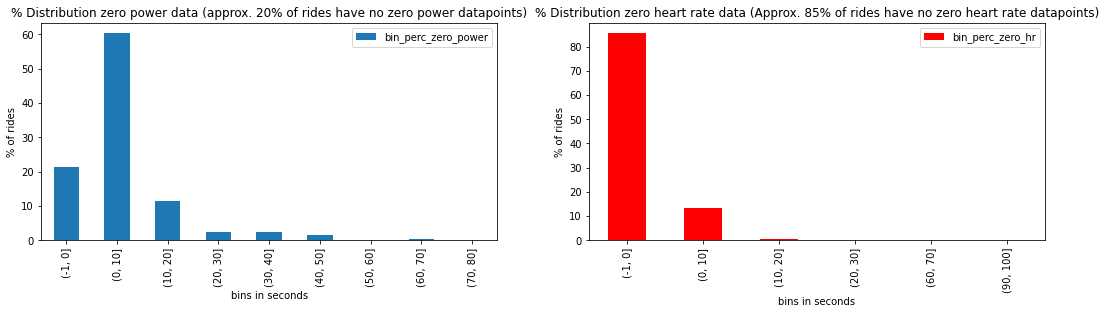

In [116]:
# plot percentages of ride with levels of zero power / zero heart rate percentages

fig, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(18,4))

cut_bins_power = [-1, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
df_stats['bin_perc_zero_power'] = pd.cut(df_stats['perc_count_zero_power'],bins=cut_bins_power) # labels=cut_labels_4)
#print(df_raw_1_stats.ride_time_sec_bin.nunique())
(df_stats['bin_perc_zero_power'].value_counts(dropna=True, normalize=True)*100).to_frame().sort_index().query("bin_perc_zero_power>0").plot(kind='bar', ax=ax1);
ax1.set_title('% Distribution zero power data (approx. 20% of rides have no zero power datapoints)')
ax1.set_xlabel('bins in seconds')
ax1.set_ylabel('% of rides');

cut_bins = [-1, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
df_stats['bin_perc_zero_hr'] = pd.cut(df_stats['perc_count_zero_hr'],bins=cut_bins) # labels=cut_labels_4)
#print(df_raw_1_stats.ride_time_sec_bin.nunique())
(df_stats['bin_perc_zero_hr'].value_counts(dropna=True, normalize=True)*100).to_frame().sort_index().query("bin_perc_zero_hr>0").plot(kind='bar', ax=ax2, color='r');
ax2.set_title('% Distribution zero heart rate data (Approx. 85% of rides have no zero heart rate datapoints)');
ax2.set_xlabel('bins in seconds')
ax2.set_ylabel('% of rides');

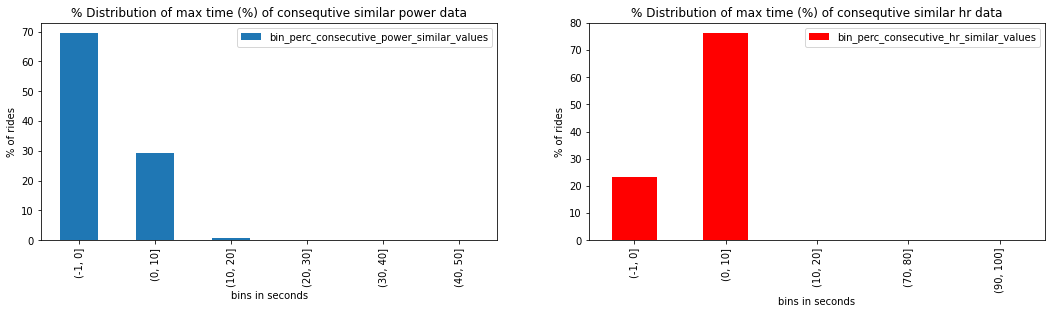

In [120]:
# plot maximum time of ride consecutive similar power / heart rate values

fig, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(18,4))

cut_bins = [-1, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
df_stats['bin_perc_consecutive_power_similar_values'] = pd.cut(df_stats['perc_consecutive_power_similar_values'],bins=cut_bins) # labels=cut_labels_4)
#print(df_raw_1_stats.ride_time_sec_bin.nunique())
(df_stats['bin_perc_consecutive_power_similar_values'].value_counts(dropna=True, normalize=True)*100).to_frame().sort_index().query("bin_perc_consecutive_power_similar_values>0").plot(kind='bar', ax=ax1);
ax1.set_title('% Distribution of max time (%) of consequtive similar power data')
ax1.set_xlabel('bins in seconds')
ax1.set_ylabel('% of rides')

cut_bins = [-1, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
df_stats['bin_perc_consecutive_hr_similar_values'] = pd.cut(df_stats['perc_consecutive_hr_similar_values'],bins=cut_bins) # labels=cut_labels_4)
(df_stats['bin_perc_consecutive_hr_similar_values'].value_counts(dropna=True, normalize=True)*100).to_frame().sort_index().query("bin_perc_consecutive_hr_similar_values>0").plot(kind='bar', ax=ax2, color='r');
ax2.set_title('% Distribution of max time (%) of consequtive similar hr data')
ax2.set_xlabel('bins in seconds')
ax2.set_ylabel('% of rides');

We see that about 70% have 0 consecutive similar power values. After around 10 similar consecutive values it might be interesting to investigate further. For heart rate it is much more "normal" to have multiple similar values (as said before heart rate is also more stable that power). It is actually interesting to investigate rides which fall out of the 1-10 range

To conclude we show some rides based on the dataframe of our overall ride statistics (df_stats) which we will use in our next notebook **1 Data processing.ipynb** to detect anomalies. As we will see handling the outliers is a very iterative process. We use a small function for this in which we can determine on which possible anomaly we want to filter and the amount of examples we would like to see. For the variable we select the top n (which we can specify) rides with the specific variable condition (value sorted) are shown in graphs

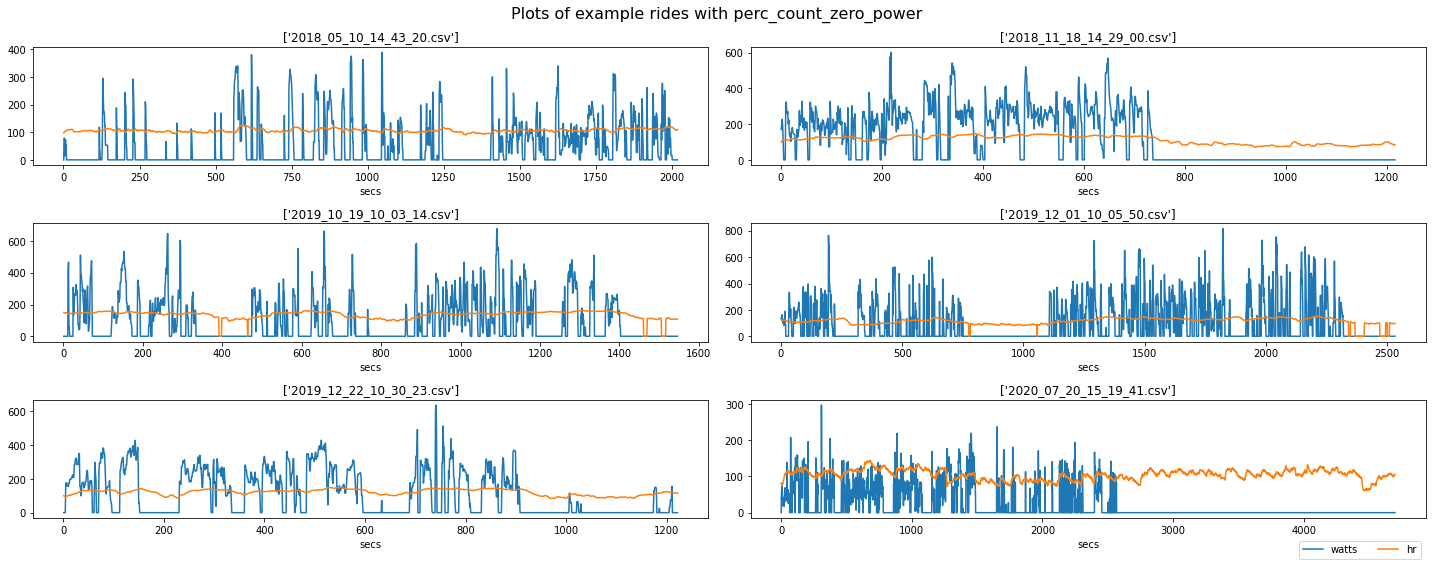

In [9]:
# invoke anomalies function
graph_ride_anomalies(df_raw, df_stats, 6, 'perc_count_zero_power', 3, 2)

By manual iterating over the specific variables which might cause problems within a ride we are able to pinpoint possible remedies. In the above example we see (long) ranges of zero power which we might want to delete (e.g. at the end of files). As stated this will be the _main focus_ in our next notebook

## Conclusion part 1
We have looked at the data from some different angles: individual second by second data and ride level statistics. This gave us an inital idea on our data like distributions, possible anomalies and some simple relations between the variables and heart rate. 

It became clear that simply deriving features from the raw data would not be a good idea. A lot of different data anomalies seem to exist for which we want to correct. To find those anomalies and take corrective action is a challenge when going over more than 4 million datapoints. Our next notebook **1. Data processing.ipynb** will go into more detail on ways to deal with the data anomalies.

# Part 2 Trainingload/stress / CP metrics and additional ride summary statistics

Next to second by second ride level data we have (aggregate) data from an external (open source) cycling analytics tool called Golden Cheetah (https://www.goldencheetah.org/). Like the ride file .csv data we also exported training load / CP data and aggregated summary statistics of the rides. We first process the training load / CP data and then the summary statistics. In addition we provide some small visualisations. The data will be used in the notebook **2. Feature engineering.ipynb**

In [10]:
# Read in dataset
df_PMC_CP = pd.read_csv('GC_PMC_CP_data.csv', sep=';')

# replace date format (Note this file had Dutch month names)
def process_pmc_files(df):
    df.columns=df.columns.str.strip()
    df.columns=df.columns.str.replace('\s+', '_')
    df['Date']=df['Date'].str.replace(" ","/")
    df['Date']=df['Date'].str.replace("jan","01")
    df['Date']=df['Date'].str.replace("feb","02")
    df['Date']=df['Date'].str.replace("mrt","03")
    df['Date']=df['Date'].str.replace("apr","04")
    df['Date']=df['Date'].str.replace("mei","05")
    df['Date']=df['Date'].str.replace("jun","06")
    df['Date']=df['Date'].str.replace("jul","07")
    df['Date']=df['Date'].str.replace("aug","08")
    df['Date']=df['Date'].str.replace("sep","09")
    df['Date']=df['Date'].str.replace("okt","10")
    df['Date']=df['Date'].str.replace("nov","11")
    df['Date']=df['Date'].str.replace("dec","12")
    #df.Date = pd.to_datetime(df.Date)
    df.set_index('Date', inplace=True)
    return df

# Process df
df_PMC_CP = process_pmc_files(df_PMC_CP)

In [11]:
df_PMC_CP.columns

Index(['ATL', 'CTL', 'TSB', 'TRIMP_Short_Term_Stress',
       'TRIMP_Long_Term_Stress', 'TRIMP_Stress_Balance', 'CP_(Ext)'],
      dtype='object')

Several variables are in the file:
* ATL = Acute Training Load (power based)
* CTL = Chronic Training Load (power based)
* TSB = Trainings Stress Balance (power based)
* TRIMP_Short_Term_Stress = Acute Training Stress (heart rate based)
* TRIMP_Long_Term_Stress = Chronic Training Stress (heart rate based)
* TRIMP_Stress_Balance = Training Stress (heart rate based)
* CP_(Ext) = Critical Power estimate (based on Extended Model)

For more explanation on these concepts see **Literature** at the end of this notebook

interval columns not set, guessing: ['ATL', 'CTL', 'TSB', 'TRIMP_Short_Term_Stress', 'TRIMP_Long_Term_Stress', 'TRIMP_Stress_Balance', 'CP_(Ext)']


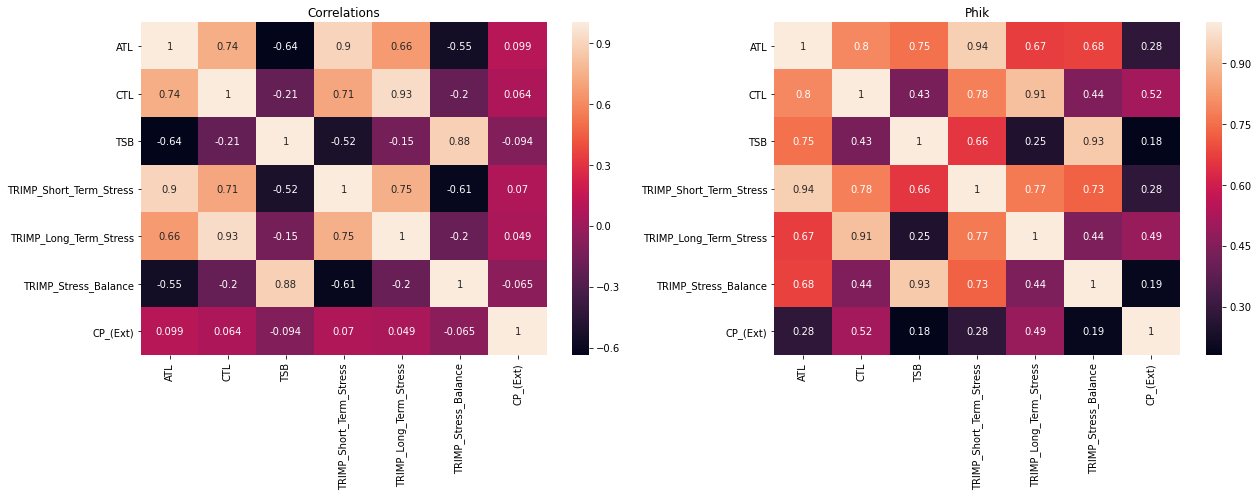

In [14]:
# Plot correlations and phik

# using the variable axs for multiple Axes
fig, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(18,7))

sns.heatmap(df_PMC_CP.corr(), annot=True, ax=ax1);
ax1.set_title('Correlations');

sns.heatmap(df_PMC_CP.phik_matrix(), annot=True, ax=ax2);
ax2.set_title('Phik')

plt.tight_layout()

In [28]:
# By making indices we can see whether there are more non-linear of linear relations between the variables. In general more non-linear as we can see (index>100)

np.round((df_PMC_CP.phik_matrix() / abs(df_PMC_CP.corr()))*100,0)

interval columns not set, guessing: ['ATL', 'CTL', 'TSB', 'TRIMP_Short_Term_Stress', 'TRIMP_Long_Term_Stress', 'TRIMP_Stress_Balance', 'CP_(Ext)']


,ATL,CTL,TSB,TRIMP_Short_Term_Stress,TRIMP_Long_Term_Stress,TRIMP_Stress_Balance,CP_(Ext)
ATL,100.0,107.0,118.0,104.0,101.0,123.0,284.0
CTL,107.0,100.0,204.0,110.0,97.0,218.0,806.0
TSB,118.0,204.0,100.0,126.0,167.0,105.0,193.0
TRIMP_Short_Term_Stress,104.0,110.0,126.0,100.0,103.0,120.0,405.0
TRIMP_Long_Term_Stress,101.0,97.0,167.0,103.0,100.0,223.0,998.0
TRIMP_Stress_Balance,123.0,218.0,105.0,120.0,223.0,100.0,296.0
CP_(Ext),284.0,806.0,193.0,405.0,998.0,296.0,100.0


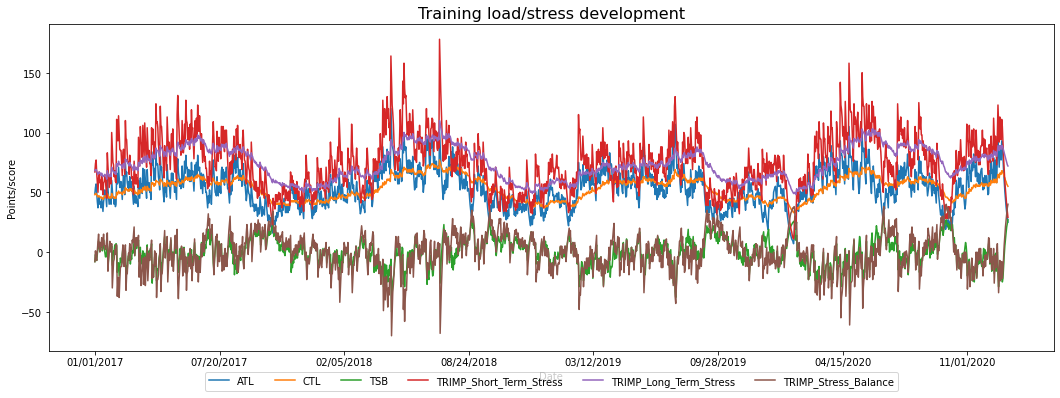

In [32]:
# Plot the overtime development of the variables related to training load/stress

fig = plt.figure()
ax = plt.subplot(111)

df_PMC_CP[['ATL', 'CTL', 'TSB', 'TRIMP_Short_Term_Stress',
       'TRIMP_Long_Term_Stress', 'TRIMP_Stress_Balance']].plot(figsize=(18,6), ax=ax);

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=False, ncol=6)

plt.ylabel('Points/score')
plt.title('Training load/stress development', fontsize=16);

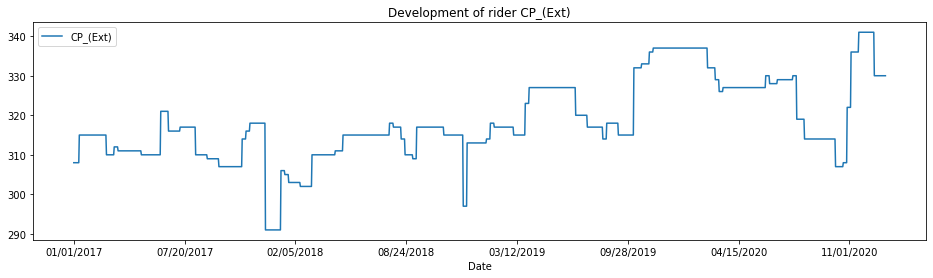

In [33]:
# plot CP development

df_PMC_CP[['CP_(Ext)']].plot(figsize=(16,4))
plt.title('Development of rider CP_(Ext)');

**Observations**

We can see that in general there is a trend of the rider improving. We also note that the sudden deviations to higher level and lower level don't come as abruptly as would a "normal" rider development in critical power. These deviations come from datapoints which are used to calculate the critical power using a sliding window approach. If all points within the window are suddenly suboptimal (read submaximal) it will influence the model and thus the calculation of critical power. Careful tracking and notation of this value (either with or without manual correction by the rider/coach) is an important factor to "level" the riders capability in relation to heart rate as we will see later in this project

In [34]:
## Read in activity file aggregated data 

df_activities = pd.read_csv('Activities.csv')

df_activities.columns=df_activities.columns.str.strip()
df_activities.columns=df_activities.columns.str.replace('\s+', '_')

df_activities['date'] = pd.to_datetime(df_activities['date'].apply(lambda x: x.split('/')[0]) + "/" + df_activities['date'].apply(lambda x: x.split('/')[1]) + "/" + df_activities['date'].apply(lambda x: "20" + x.split('/')[2]))

df_activities['filename'] = df_activities.filename.str.replace("json","csv")

# add hour of day as variable (when .30 round back, otherwise to next hour)
df_activities['start_hour_of_day_activity'] = np.where(df_activities.time.apply(lambda x: x.split(':')[1]).astype(int)>30, df_activities.time.apply(lambda x: x.split(':')[0]).astype(int)+1, df_activities.time.apply(lambda x: x.split(':')[0]).astype(int))

df_activities = df_activities[['date','time','start_hour_of_day_activity','filename','Average_Cadence','Average_Power','BikeScore','Duration','Relative_Intensity',
                               'Nonzero_Average_Power','Time_Moving','TRIMP(100)_Points','TRIMP_Points','TRIMP_Zonal_Points','xPower']]

interval columns not set, guessing: ['Average_Cadence', 'Average_Power', 'BikeScore', 'Duration', 'Relative_Intensity', 'Nonzero_Average_Power', 'start_hour_of_day_activity', 'Time_Moving', 'TRIMP(100)_Points', 'TRIMP_Points', 'TRIMP_Zonal_Points', 'xPower']


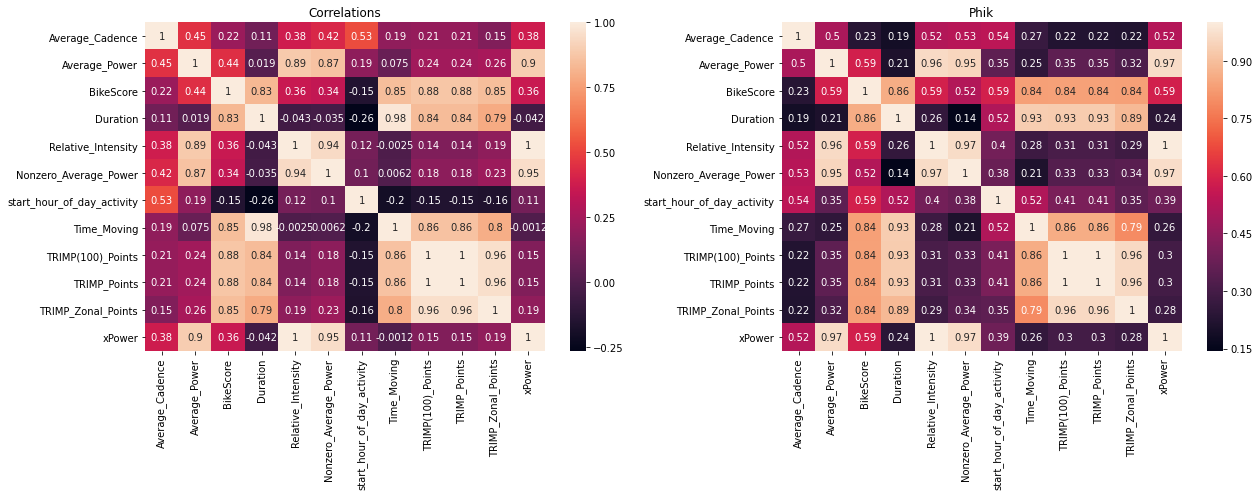

In [35]:
# Plot correlations and phik

cols = ['Average_Cadence','Average_Power','BikeScore','Duration','Relative_Intensity',
                               'Nonzero_Average_Power','start_hour_of_day_activity',
    'Time_Moving','TRIMP(100)_Points','TRIMP_Points','TRIMP_Zonal_Points','xPower']

# using the variable axs for multiple Axes
fig, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(18,7))

sns.heatmap(df_activities[cols].corr(), annot=True, ax=ax1);
ax1.set_title('Correlations');

sns.heatmap(df_activities[cols].phik_matrix(), annot=True, ax=ax2);
ax2.set_title('Phik')

plt.tight_layout()

For more explanation on these concepts see **Literature** at the end of this notebook

In [37]:
# By making indices we can see whether there are more non-linear of linear relations between the variables. In general more non-linear as we can see (index>100)

np.round((df_activities[cols].phik_matrix() / abs(df_activities[cols].corr()))*100,0)

interval columns not set, guessing: ['Average_Cadence', 'Average_Power', 'BikeScore', 'Duration', 'Relative_Intensity', 'Nonzero_Average_Power', 'start_hour_of_day_activity', 'Time_Moving', 'TRIMP(100)_Points', 'TRIMP_Points', 'TRIMP_Zonal_Points', 'xPower']


,Average_Cadence,Average_Power,BikeScore,Duration,Relative_Intensity,Nonzero_Average_Power,start_hour_of_day_activity,Time_Moving,TRIMP(100)_Points,TRIMP_Points,TRIMP_Zonal_Points,xPower
Average_Cadence,100.0,111.0,105.0,180.0,137.0,127.0,102.0,141.0,108.0,108.0,145.0,138.0
Average_Power,111.0,100.0,132.0,1119.0,108.0,110.0,187.0,338.0,145.0,145.0,121.0,108.0
BikeScore,105.0,132.0,100.0,104.0,164.0,152.0,401.0,99.0,96.0,96.0,98.0,163.0
Duration,180.0,1119.0,104.0,100.0,601.0,416.0,196.0,95.0,110.0,110.0,112.0,571.0
Relative_Intensity,137.0,108.0,164.0,601.0,100.0,102.0,342.0,11086.0,214.0,214.0,151.0,100.0
Nonzero_Average_Power,127.0,110.0,152.0,416.0,102.0,100.0,367.0,3467.0,183.0,183.0,151.0,101.0
start_hour_of_day_activity,102.0,187.0,401.0,196.0,342.0,367.0,100.0,260.0,265.0,265.0,224.0,350.0
Time_Moving,141.0,338.0,99.0,95.0,11086.0,3467.0,260.0,100.0,100.0,100.0,99.0,22180.0
TRIMP(100)_Points,108.0,145.0,96.0,110.0,214.0,183.0,265.0,100.0,100.0,100.0,100.0,201.0
TRIMP_Points,108.0,145.0,96.0,110.0,214.0,183.0,265.0,100.0,100.0,100.0,100.0,201.0


## Conclusion part 2
* Load/stress metrics relations are stronger in a non-linear way than linear: this can be deducted from looking at correlation and phik matrices
* Level of TRIMP based load is different: however this difference is leveled out in stress balance
* CP (Ext) is a modelled metric and uses datapoints from a moving window. If no hard efforts are done in those durations the threshold values deviate. For now we will use this modelled data of the rider's "threshold" development
* Note: We have decided to use data coming from an open source platform. We have (not included in all the documents) experiments with commercial software related training concepts using WKO5. These results do not substantially influence the outcomes of the modelling and can as such be used as substitutes

Make pickle files for further use in notebook **2. Feature engineering.ipynb**

In [ ]:
df_PMC_CP.to_pickle('df_PMC_CP.pkl')

df_activities.to_pickle('df_summary_statistics.pkl')

### Literature

* Rationale and resources for teaching the mathematical modeling of athletic training and performance, David C Clarke, Philip F Skiba, Advances in Physiology Education, 2013 Jun; 37(2): 134-52. doi: 10.1152/advan.00078.2011

PDF available at : https://pdfs.semanticscholar.org/3726/b494e02c490c06a2f62b94d71adca719cea8.pdf?_ga=2.41085794.1985086388.1613036885-1288018597.1594574849

**CP modelling**
- http://veloclinic.com/wp-content/uploads/2014/04/PowerModelDerivation-1.pdf
- https://3record.de/about/pd_model
- https://github.com/GoldenCheetah/GoldenCheetah/blob/master/src/Metrics/ExtendedCriticalPower.cpp     